# Week 2: Designing Machine Learning Workflows

___
- Thinking from Engineer POV: what does it mean to build this application from an engineering context?
- How to build ML workflows with Metaflow
- Versioning, model reporting, and notebooks
- Iterative approach to building ML workflows
___

## Engineer POV

## Building ML workflows with Metaflow

An improved version of the flow:
- Leave the baseline in a separate branch
- Create a step that performs basic featurization
- Train/test split
- Train a model
- Produce predictions


## The Unreasonable Effective of Branching Flows

Often, you'll want to train several independent models and then choose the best one. As they're indepedendent, you can train them in parallel. For this, you can use the concept of branching, which is exemplified in this figure:


<img src="../img/flow_ex_0.png" alt="DAG" style="width: 400px;"/>

Let's now do this in Metaflow by writing a flow that has random forests, decision trees, and extra trees classifiers, trains them all and chooses the best one.

The following flow so that it has random forests, decision trees, and extra trees classifiers, trains them all and chooses the best one.

In [1]:
%%writefile ../flows/local/tree_branch_flow.py

from metaflow import FlowSpec, step, card

class Branch_Flow(FlowSpec):
    """
    train multiple tree based methods
    """
    @card 
    @step
    def start(self):
        """
        Load the data
        """
        #Import scikit-learn dataset library
        from sklearn import datasets

        #Load dataset
        self.iris = datasets.load_iris()
        self.X = self.iris['data']
        self.y = self.iris['target']
        self.next(self.rf_model, self.xt_model, self.dt_model)
    
                
    @step
    def rf_model(self):
        """
        build random forest model
        """
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.model_selection import cross_val_score
        
        self.clf = RandomForestClassifier(n_estimators=10, max_depth=None,
            min_samples_split=2, random_state=0)
        self.scores = cross_val_score(self.clf, self.X, self.y, cv=5)
        self.next(self.choose_model)

    @step
    def xt_model(self):
        """
        build extra trees classifier
        """
        from sklearn.ensemble import ExtraTreesClassifier
        from sklearn.model_selection import cross_val_score
        

        self.clf = ExtraTreesClassifier(n_estimators=10, max_depth=None,
            min_samples_split=2, random_state=0)

        self.scores = cross_val_score(self.clf, self.X, self.y, cv=5)
        self.next(self.choose_model)

    @step
    def dt_model(self):
        """
        build decision tree classifier
        """
        from sklearn.tree import DecisionTreeClassifier
        from sklearn.model_selection import cross_val_score
        
        self.clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
            random_state=0)

        self.scores = cross_val_score(self.clf, self.X, self.y, cv=5)

        self.next(self.choose_model)
                        
    @step
    def choose_model(self, inputs):
        """
        find 'best' model
        """
        import numpy as np

        def score(inp):
            return inp.clf,\
                   np.mean(inp.scores)

            
        self.results = sorted(map(score, inputs), key=lambda x: -x[1]) 
        self.model = self.results[0][0]
        self.next(self.end)
        
    @step
    def end(self):
        """
        End of flow!
        """
        print('Scores:')
        print('\n'.join('%s %f' % res for res in self.results))
        print('Best model:')
        print(self.model)


if __name__ == "__main__":
    Branch_Flow()

Overwriting ../flows/local/tree_branch_flow.py


Execute the above from the command line with

```bash
python flows/local/tree_branch_flow.py run
```

In [2]:
! python ../flows/local/tree_branch_flow.py run

Metaflow 2.7.21.4 executing Branch_Flow for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-04-05 17:07:31.533 Workflow starting (run-id 32), see it in the UI at https://ui-pw-233796051.outerbounds.dev/Branch_Flow/32
2023-04-05 17:07:31.841 [32/start/152 (pid 28289)] Task is starting.
2023-04-05 17:07:39.485 [32/start/152 (pid 28289)] Task finished successfully.
2023-04-05 17:07:39.806 [32/rf_model/153 (pid 28450)] Task is starting.
2023-04-05 17:07:40.037 [32/xt_model/154 (pid 28453)] Task is starting.
2023-04-05 17:07:40.239 [32/dt_model/155 (pid 28457)] Task is starting.
2023-04-05 17:07:47.149 [32/rf_model/153 (pid 28450)] Task finished successfully.
2023-04-05 17:07:47.528 [32/xt_model/154 (pid 28453)] Task finished successfully.
2023-04-05 17:07:47.943 [32/dt_model/155 (pid 28457)] Task finished successfully.
2023-04-05 17:07:48.441 [32/choose_model/156 (pid 28756)] Task is starting.
2023-04-05 17:07:53.637 [32/choose_mod

We can also view the Metaflow card:

```
python flows/local/tree_branch_flow.py card view start
```

In [3]:
! python ../flows/local/tree_branch_flow.py card view start

Metaflow 2.7.21.4 executing Branch_Flow for user:sandbox
Resolving card: Branch_Flow/32/start/152


## Branching flows with the Titanic

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_csv('../data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


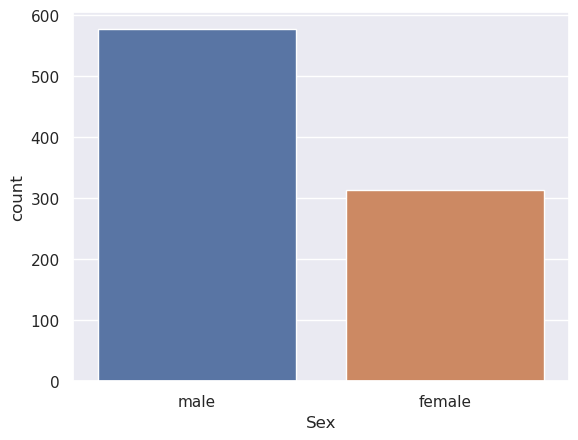

In [5]:
sns.countplot(x='Sex', data=df);

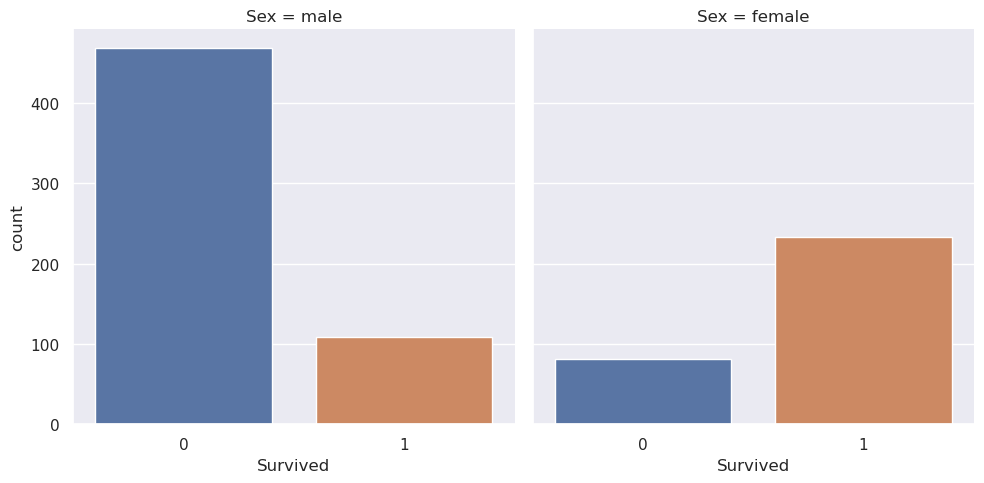

In [6]:
sns.catplot(x='Survived', col='Sex', kind='count', data=df);

In [7]:
from sklearn.metrics import accuracy_score

df['model_1'] = 0
accuracy_score(df['Survived'], df['model_1'])

0.6161616161616161

In [8]:
df['model_2'] = df.Sex == 'female'
accuracy_score(df['Survived'], df['model_2'])

0.7867564534231201

In [9]:
%%writefile ../flows/local/titanic_flow_1.py

from metaflow import FlowSpec, step, card


class TFlow1(FlowSpec):
    
    @card
    @step
    def start(self):
        """
        Load the data & train model
        """
        import pandas as pd
        self.df = pd.read_csv('../data/titanic.csv')
        self.next(self.predict)
        
    @step
    def predict(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.df['model_1'] = 0
        self.score1 = accuracy_score(self.df['Survived'], self.df['model_1'])


        self.next(self.end)
        
        
    @step
    def end(self):
        """
        End of flow!
        """
        print('Score = %s' % self.score1)


if __name__ == "__main__":
    TFlow1()

Overwriting ../flows/local/titanic_flow_1.py


In [10]:
! python ../flows/local/titanic_flow_1.py run

Metaflow 2.7.21.4 executing TFlow1 for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-04-05 17:08:12.316 Workflow starting (run-id 33), see it in the UI at https://ui-pw-233796051.outerbounds.dev/TFlow1/33
2023-04-05 17:08:12.627 [33/start/159 (pid 29061)] Task is starting.
2023-04-05 17:08:18.817 [33/start/159 (pid 29061)] Task finished successfully.
2023-04-05 17:08:19.229 [33/predict/160 (pid 29195)] Task is starting.
2023-04-05 17:08:22.790 [33/predict/160 (pid 29195)] Task finished successfully.
2023-04-05 17:08:23.121 [33/end/161 (pid 29270)] Task is starting.
2023-04-05 17:08:25.015 [33/end/161 (pid 29270)] Score = 0.6161616161616161
2023-04-05 17:08:26.119 [33/end/161 (pid 29270)] Task finished successfully.
2023-04-05 17:08:26.285 Done! See the run in the UI at https://ui-pw-233796051.outerbounds.dev/TFlow1/33


In [11]:
%%writefile ../flows/local/titanic_flow_2.py

from metaflow import FlowSpec, step, card


class TFlow2(FlowSpec):
    """
    train a boosted tree
    """
    @card
    @step
    def start(self):
        
        import pandas as pd
        self.df = pd.read_csv('../data/titanic.csv')
        self.next(self.predict)
        
    @step
    def predict(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.df['model_2'] = self.df.Sex == 'female'
        self.score2 = accuracy_score(self.df['Survived'], self.df['model_2'])


        self.next(self.end)
        
        
    @step
    def end(self):
        """
        End of flow!
        """
        print('Score = %s' % self.score2)
        
        print("TFlow2 is all done.")


if __name__ == "__main__":
    TFlow2()

Overwriting ../flows/local/titanic_flow_2.py


In [12]:
! python ../flows/local/titanic_flow_2.py run

Metaflow 2.7.21.4 executing TFlow2 for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-04-05 17:08:34.959 Workflow starting (run-id 34), see it in the UI at https://ui-pw-233796051.outerbounds.dev/TFlow2/34
2023-04-05 17:08:35.290 [34/start/163 (pid 29383)] Task is starting.
2023-04-05 17:08:41.221 [34/start/163 (pid 29383)] Task finished successfully.
2023-04-05 17:08:41.578 [34/predict/164 (pid 29517)] Task is starting.
2023-04-05 17:08:45.427 [34/predict/164 (pid 29517)] Task finished successfully.
2023-04-05 17:08:45.729 [34/end/165 (pid 29592)] Task is starting.
2023-04-05 17:08:47.503 [34/end/165 (pid 29592)] Score = 0.7867564534231201
2023-04-05 17:08:48.239 [34/end/165 (pid 29592)] TFlow2 is all done.
2023-04-05 17:08:48.609 [34/end/165 (pid 29592)] Task finished successfully.
2023-04-05 17:08:48.755 Done! See the run in the UI at https://ui-pw-233796051.outerbounds.dev/TFlow2/34


In [13]:
%%writefile ../flows/local/titanic_flow_3.py

from metaflow import FlowSpec, step, card


class TFlow3(FlowSpec):
    """
    train a boosted tree
    """
    @card
    @step
    def start(self):
        """
        Load the data & train model
        """
        import pandas as pd
        self.df = pd.read_csv('../data/titanic.csv')
        self.next(self.model1, self.model2)


    @step
    def model1(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.clf = 'model_1'
        self.df['model'] = 0
        self.score = accuracy_score(self.df['Survived'], self.df['model'])

        self.next(self.choose_model)
        
        
    @step
    def model2(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.clf = 'model_2'
        self.df['model'] = self.df.Sex == 'female'
        self.score = accuracy_score(self.df['Survived'], self.df['model'])
        
        self.next(self.choose_model)
        
    @step
    def choose_model(self, inputs):
        """
        find 'best' model
        """
        import numpy as np

        def score(inp):
            return inp.clf,\
                   inp.score

            
        self.results = sorted(map(score, inputs), key=lambda x: -x[1]) 
        self.model = self.results[0][0]
        
        self.next(self.end)


    @step
    def end(self):
        """
        End of flow!
        """
        print('Scores:')
        print('\n'.join('%s %f' % res for res in self.results))
        print('Best model:')
        print(self.model)
        print("TFlow3 is all done.")


if __name__ == "__main__":
    TFlow3()

Overwriting ../flows/local/titanic_flow_3.py


In [14]:
! python ../flows/local/titanic_flow_3.py run 

Metaflow 2.7.21.4 executing TFlow3 for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-04-05 17:08:57.157 Workflow starting (run-id 35), see it in the UI at https://ui-pw-233796051.outerbounds.dev/TFlow3/35
2023-04-05 17:08:57.501 [35/start/167 (pid 29705)] Task is starting.
2023-04-05 17:09:03.403 [35/start/167 (pid 29705)] Task finished successfully.
2023-04-05 17:09:03.753 [35/model1/168 (pid 29839)] Task is starting.
2023-04-05 17:09:03.980 [35/model2/169 (pid 29842)] Task is starting.
2023-04-05 17:09:09.400 [35/model1/168 (pid 29839)] Task finished successfully.
2023-04-05 17:09:09.772 [35/model2/169 (pid 29842)] Task finished successfully.
2023-04-05 17:09:10.168 [35/choose_model/170 (pid 30043)] Task is starting.
2023-04-05 17:09:14.647 [35/choose_model/170 (pid 30043)] Task finished successfully.
2023-04-05 17:09:15.021 [35/end/171 (pid 30145)] Task is starting.
2023-04-05 17:09:16.743 [35/end/171 (pid 30145)] Scores:


A notebook (cell) that compares the baseline to the ML version: evaluating results across steps / versions using the Client API.

In [15]:
from metaflow import Flow
name = 'TFlow3'
run = Flow(name).latest_run
print(run.successful)

True


In [16]:
print(run)

Run('TFlow3/35')


In [17]:
run.data.results

[('model_2', 0.7867564534231201), ('model_1', 0.6161616161616161)]

## ML models

In [18]:
df = pd.read_csv('../data/titanic.csv')


# Store target variable of training data in a safe place
survived = df.Survived
df = df.drop(['Survived'], axis=1)

# Impute missing numerical variables
df['Age'] = df.Age.fillna(df.Age.median())
df['Fare'] = df.Fare.fillna(df.Fare.median())

# Check out info of data
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [19]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df = df[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]
df.head()

,Sex_male,Fare,Age,Pclass,SibSp
0,1,7.2500,22.0,3,1
1,0,71.2833,38.0,1,1
2,0,7.9250,26.0,3,0
3,0,53.1000,35.0,1,1
4,1,8.0500,35.0,3,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex_male  891 non-null    uint8  
 1   Fare      891 non-null    float64
 2   Age       891 non-null    float64
 3   Pclass    891 non-null    int64  
 4   SibSp     891 non-null    int64  
dtypes: float64(2), int64(2), uint8(1)
memory usage: 28.8 KB


In [21]:
X = df.values
y = survived.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


In [22]:
from sklearn import tree

# Instantiate model and fit to data
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8203389830508474

In [23]:
%%writefile ../flows/local/titanic_flow_4.py

from metaflow import FlowSpec, step, card


class TFlow4(FlowSpec):
    """
    train a boosted tree
    """
    @card
    @step
    def start(self):
        """
        Load the data & train model
        """
        import pandas as pd
        self.df = pd.read_csv('../data/titanic.csv')
        self.next(self.model1, self.model2, self.data_prep)


    @step
    def model1(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.clf = 'model_1'
        self.df['model'] = 0
        self.score = accuracy_score(self.df['Survived'], self.df['model'])

        self.next(self.choose_model)
        
        
    @step
    def model2(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.clf = 'model_2'
        self.df['model'] = self.df.Sex == 'female'
        self.score = accuracy_score(self.df['Survived'], self.df['model'])
        
        self.next(self.choose_model)

    @step
    def data_prep(self):
        """
        prep data for tree-based model
        """
        import pandas as pd
        # Store target variable of training data in a safe place
        survived = self.df.Survived

        # 
        df = self.df.drop(['Survived'], axis=1)

        # Impute missing numerical variables
        df['Age'] = df.Age.fillna(df.Age.median())
        df['Fare'] = df.Fare.fillna(df.Fare.median())

        df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
        df = df[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]

        X = df.values
        y = survived.values

        from sklearn.model_selection import train_test_split

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.33, random_state=42)



        self.next(self.model3)


    @step
    def model3(self):
        """
        make predictions
        """
        from sklearn import tree

        # Instantiate model and fit to data
        self.clf = tree.DecisionTreeClassifier(max_depth=3)
        self.clf.fit(self.X_train, self.y_train)
        self.score = self.clf.score(self.X_test, self.y_test)

        self.next(self.choose_model)
        
    @step
    def choose_model(self, inputs):
        """
        find 'best' model
        """
        import numpy as np

        def score(inp):
            return inp.clf,\
                   inp.score

            
        self.results = sorted(map(score, inputs), key=lambda x: -x[1]) 
        self.model = self.results[0][0]
        
        self.next(self.end)


    @step
    def end(self):
        """
        End of flow!
        """
        print('Scores:')
        print('\n'.join('%s %f' % res for res in self.results))
        print('Best model:')
        print(self.model)
        print("TFlow4 is all done.")


if __name__ == "__main__":
    TFlow4()

Overwriting ../flows/local/titanic_flow_4.py


In [24]:
! python ../flows/local/titanic_flow_4.py run 

Metaflow 2.7.21.4 executing TFlow4 for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-04-05 17:09:28.378 Workflow starting (run-id 36), see it in the UI at https://ui-pw-233796051.outerbounds.dev/TFlow4/36
2023-04-05 17:09:28.703 [36/start/173 (pid 30266)] Task is starting.
2023-04-05 17:09:34.970 [36/start/173 (pid 30266)] Task finished successfully.
2023-04-05 17:09:35.406 [36/model1/174 (pid 30400)] Task is starting.
2023-04-05 17:09:35.614 [36/model2/175 (pid 30403)] Task is starting.
2023-04-05 17:09:35.833 [36/data_prep/176 (pid 30407)] Task is starting.
2023-04-05 17:09:43.200 [36/model2/175 (pid 30403)] Task finished successfully.
2023-04-05 17:09:43.551 [36/model1/174 (pid 30400)] Task finished successfully.
2023-04-05 17:09:43.810 [36/data_prep/176 (pid 30407)] Task finished successfully.
2023-04-05 17:09:44.409 [36/model3/177 (pid 30706)] Task is starting.
2023-04-05 17:09:49.315 [36/model3/177 (pid 30706)] Task fin

## Iterative approach to building ML workflows: a scalable model

A flow that performs hyperparam search using foreach for the ML model, runs –with kubernetes, compare results in a notebook.

How to improve model incrementally, benefits of the compute layer using Foreach, @resources, @kubernetes, @card.

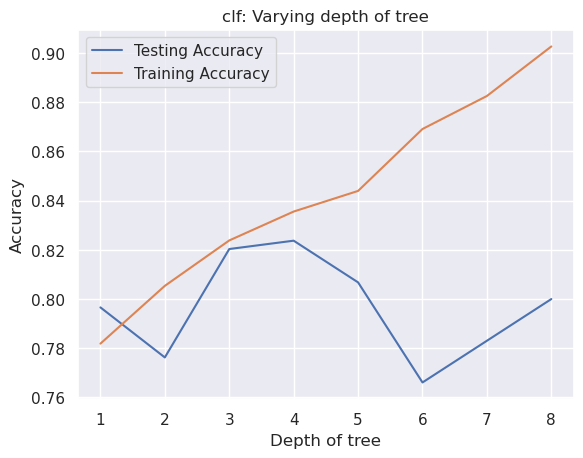

In [25]:
import numpy as np

# Setup arrays to store train and test accuracies
dep = np.arange(1, 9)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a tree classifier with max depth k
    clf = tree.DecisionTreeClassifier(max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

In [26]:
%%writefile ../flows/local/titanic_flow_5.py

from metaflow import FlowSpec, step, card


class TFlow5(FlowSpec):
    """
    train a boosted tree
    """
    @card
    @step
    def start(self):
        """
        Load the data & train model
        """
        import pandas as pd
        self.df = pd.read_csv('../data/titanic.csv')
        self.next(self.data_prep)


    @step
    def data_prep(self):
        """
        prep data for tree-based model
        """
        import numpy as np
        import pandas as pd
        # Store target variable of training data in a safe place
        survived = self.df.Survived

        # 
        df = self.df.drop(['Survived'], axis=1)

        # Impute missing numerical variables
        df['Age'] = df.Age.fillna(df.Age.median())
        df['Fare'] = df.Fare.fillna(df.Fare.median())

        df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
        df = df[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]

        X = df.values
        y = survived.values

        from sklearn.model_selection import train_test_split

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.33, random_state=42)

        self.grid_points = np.arange(1, 9)

        self.next(self.model3, foreach='grid_points')


    @step
    def model3(self):
        """
        make predictions
        """
        from sklearn import tree

        # Instantiate model and fit to data
        self.clf = tree.DecisionTreeClassifier(max_depth=self.input)
        self.clf.fit(self.X_train, self.y_train)
        self.score = self.clf.score(self.X_test, self.y_test)

        self.next(self.choose_model)
        
    @step
    def choose_model(self, inputs):
        """
        find 'best' model
        """
        import numpy as np

        def score(inp):
            return inp.clf,\
                   inp.score

            
        self.results = sorted(map(score, inputs), key=lambda x: -x[1]) 
        self.model = self.results[0][0]
        
        self.next(self.end)


    @step
    def end(self):
        """
        End of flow!
        """
        print('Scores:')
        print('\n'.join('%s %f' % res for res in self.results))
        print('Best model:')
        print(self.model)
        print("TFlow5 is all done.")


if __name__ == "__main__":
    TFlow5()

Overwriting ../flows/local/titanic_flow_5.py


In [27]:
! python ../flows/local/titanic_flow_5.py run 

Metaflow 2.7.21.4 executing TFlow5 for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-04-05 17:10:08.382 Workflow starting (run-id 37), see it in the UI at https://ui-pw-233796051.outerbounds.dev/TFlow5/37
2023-04-05 17:10:08.694 [37/start/181 (pid 31039)] Task is starting.
2023-04-05 17:10:14.832 [37/start/181 (pid 31039)] Task finished successfully.
2023-04-05 17:10:15.251 [37/data_prep/182 (pid 31173)] Task is starting.
2023-04-05 17:10:20.379 [37/data_prep/182 (pid 31173)] Foreach yields 8 child steps.
2023-04-05 17:10:20.379 [37/data_prep/182 (pid 31173)] Task finished successfully.
2023-04-05 17:10:20.805 [37/model3/183 (pid 31275)] Task is starting.
2023-04-05 17:10:20.967 [37/model3/184 (pid 31278)] Task is starting.
2023-04-05 17:10:21.165 [37/model3/185 (pid 31282)] Task is starting.
2023-04-05 17:10:21.391 [37/model3/186 (pid 31286)] Task is starting.
2023-04-05 17:10:21.802 [37/model3/187 (pid 31315)] Task is start

In [28]:
! python ../flows/local/titanic_flow_5.py card view start

Metaflow 2.7.21.4 executing TFlow5 for user:sandbox
Resolving card: TFlow5/37/start/181


In [29]:
from metaflow import Flow
name = 'TFlow5'
run = Flow(name).latest_run
print(run.successful)

True


In [30]:
run.data.results

[(DecisionTreeClassifier(max_depth=4), 0.823728813559322),
 (DecisionTreeClassifier(max_depth=3), 0.8203389830508474),
 (DecisionTreeClassifier(max_depth=8), 0.8101694915254237),
 (DecisionTreeClassifier(max_depth=5), 0.8067796610169492),
 (DecisionTreeClassifier(max_depth=1), 0.7966101694915254),
 (DecisionTreeClassifier(max_depth=7), 0.7830508474576271),
 (DecisionTreeClassifier(max_depth=2), 0.7762711864406779),
 (DecisionTreeClassifier(max_depth=6), 0.7661016949152543)]